In [80]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: marcodia
"""
import numpy as np
import random
import xarray as xr
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
import tensorflow as tf

import import_ipynb
import sys
import os 

import network_arch as network
import metrics
import plot
import settings
import functions_misc as funcs 

import cftime
import matplotlib.pyplot as plt
import nc_time_axis

from cartopy import config
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry.polygon import LinearRing

from netCDF4 import Dataset
import h5py

from scipy import stats


ln: network_arch.ipynb: File exists
ln: metrics.ipynb: File exists
ln: plot.ipynb: File exists
ln: settings.ipynb: File exists
ln: functions_misc.ipynb: File exists


In [201]:
# <<<<<< PARAMETERS >>>>>
exp_num = 1
ind = 0 
num_experiments = 10
num_seeds = 10 

#confidence params
conf_level = 'most' #OR least
statement = 20
per = 100-statement #percentile; this number can be stated as "the statement% conf_level confident predictions"; ex- the 20% most confident predictions  
subset = 'correct'
c = 1 #negative pred = 0; positive pred = 1

conf_level_2 = 'most'
statement_2 = 20
subset_2 = 'incorrect'
c_2 = 0

running_window_yr = 10 #running mean
days_per_annualszn = 30+31+31+28
running_window = running_window_yr * days_per_annualszn

YEARS = '1850-1949'
STRT = pd.to_datetime('11-01-1850')
END   = pd.to_datetime('2-28-1949')  + dt.timedelta(days=1)

STRT_index = pd.to_datetime('02-01-1850')
END_index   = pd.to_datetime('01-01-1950')  + dt.timedelta(days=1)
time_range_index = xr.cftime_range(str(STRT_index)[:10], str(END_index)[:10],calendar = 'noleap') #[0:10] corresponds to full datestamp
time_range_index

timeplot_full = np.arange(1850,1950)
array_size = len(timeplot_full) - running_window_yr
timeplot = timeplot_full[running_window_yr:(len(timeplot_full))]

NLABEL = 2


In [202]:
#Open a file to get dimensions

prect_file = xr.open_dataarray(file_readin_shape)
prect_lat = np.array(prect_file.lat)
prect_lon = np.array(prect_file.lon)
prect_time = np.array(prect_file.time)


In [204]:
# <<< EMPTY FILES FOR READING IN >>>>>>>>>>
conf_correct_preds_full = xr.DataArray(np.zeros([num_experiments,num_seeds,len(prect_lat), len(prect_lon)]),dims = ['experiment','seed', 'lat', 'lon'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)), ('lat',prect_lat), ('lon',prect_lon)])


In [206]:
#for sub_exp in np.arange(106,107):
for sub_exp in np.arange(exp_num*100,exp_num*100+10):
    EXPERIMENT = EXPERIMENT NAME #need to name from settings file

    Xdata_folder = X_DATA #data folder with x-data
    Ydata_folder = Y_DATA #data folder with y-data

    ddir_X = DIRECTORY_X
    ddir_Y = DIRECTORY_Y
    ddir_in = DIRECTORY_IN
    ddir_out = DIRECTORY_OUT 
    
    params = settings.get_settings(EXPERIMENT)

    PREDICTOR_VAR  = params['PREDICTOR_VAR']           
    PREDICTAND_VAR = params['PREDICTAND_VAR']              
    REGION_TOR     = params['REGION_TOR']          
    REGION_TAND    = params['REGION_TAND']            
    training_ens   = params['training_ens']            
    validation_ens = params['validation_ens']           
    testing_ens    = params['testing_ens']           
    train_list     = params['train_list']           
    lead           = params['lead']            
    days_average   = params['days_average']            
    GLOBAL_SEED    = params['GLOBAL_SEED']            
    HIDDENS        = params['HIDDENS']          
    DROPOUT        = params['DROPOUT']            
    RIDGE1         = params['RIDGE1']                    
    LR_INIT        = params['LR_INIT']
    BATCH_SIZE     = params['BATCH_SIZE']           
    RANDOM_SEED    = params['RANDOM_SEED']            
    act_fun        = params['act_fun']            
    N_EPOCHS       = params['N_EPOCHS']           
    PATIENCE       = params['PATIENCE']   
    
    #>>>>>SET UP <<<<<<<<<<<<<<<
    np.random.seed(GLOBAL_SEED)
    random.seed(GLOBAL_SEED)
    tf.compat.v1.random.set_random_seed(GLOBAL_SEED)
    
    time_range = xr.cftime_range(str(STRT)[:10], str(END)[:10],calendar = 'noleap') #[0:10] corresponds to full datestamp
    time_range_ndjf = time_range.where(funcs.is_ndjf(time_range.month)).dropna()
    TIME_X = xr.DataArray(time_range_ndjf + dt.timedelta(days=0), dims=['time'])     
    TIME_Y = xr.DataArray(time_range_ndjf + dt.timedelta(days=lead+days_average), dims=['time'])                                                           
    X_TEST_finame  = PREDICTOR_VAR+'_'+REGION_TOR+'_'+YEARS+'_'+'ens'+str(testing_ens)+'_dailyanom_detrend.nc'
    Xtest = xr.open_dataarray(ddir_X+X_TEST_finame)
    Xtest = Xtest.where(Xtest.time == TIME_X, drop=True)

    ind2= 0 
    for SEED in RANDOM_SEED:
        if ind2 < num_experiments:
            conf_correct_preds_full[ind,ind2,:,:] = xr.open_dataarray(ddir_in+subset+'TIMEMEAN_20perc_mostconfident_predictions_'+EXPERIMENT[-3:]+'_seed'+str(SEED)+'_class'+str(c)+'.nc')   #file made in calculate...ipynb
            ind2 = ind2+1
    ind = ind+1


In [209]:
Xtest_time = np.array(Xtest.time)
Xtest_lat = np.array(Xtest.lat)
Xtest_lon = np.array(Xtest.lon)

In [210]:
seed_avg_conf_preds = np.mean(conf_correct_preds_full, axis = 1) #take the average over the seeds

avg_conf_preds= np.mean(seed_avg_conf_preds,axis=0)

## Maps

/Users/marcodia/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/marcodia/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/Users/marcodia/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


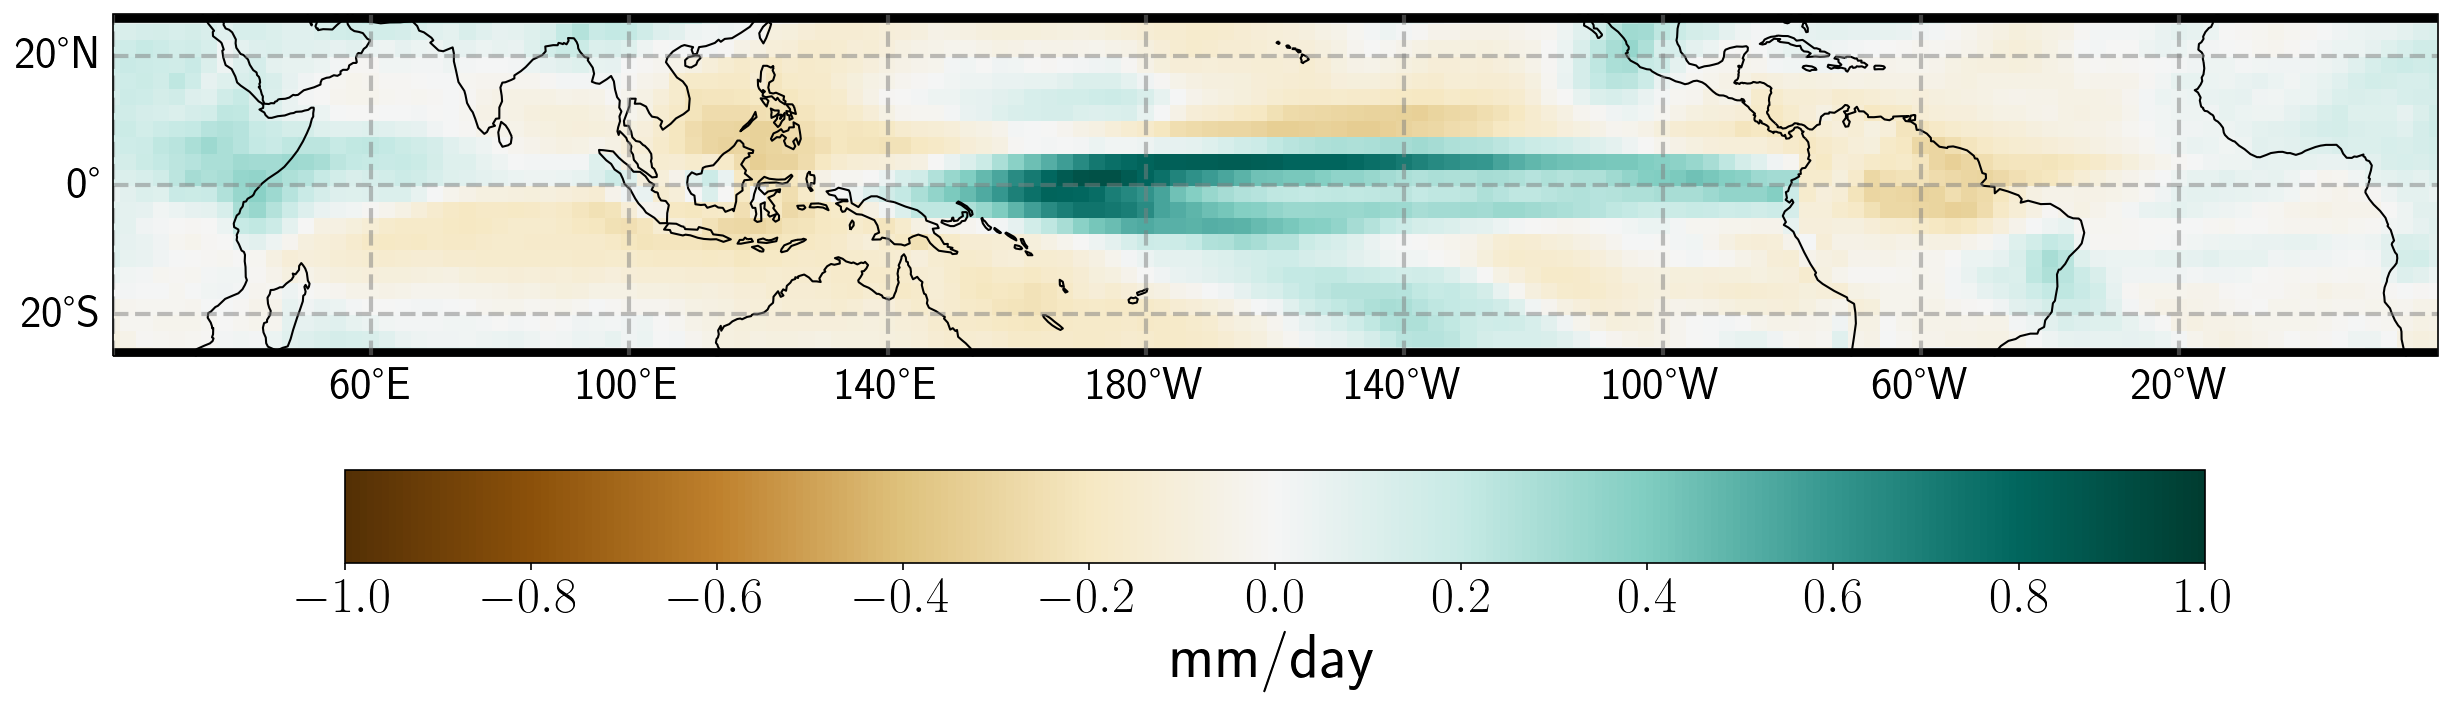

In [200]:
#Code to Plot predictor region

figure = plt.figure(figsize=(20,14))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=200))
ax.add_feature(cfeature.COASTLINE)
ax.set_extent(
    [
        0, # max longitude
        360, # min longitude
        -26.5, # max min
        26.5 # max latitude
    ],
    crs=ccrs.PlateCarree()
)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,40))
gl.ylocator = mticker.FixedLocator(np.arange(-80,80,20))

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

min_level = -1
max_level = 1
step_level = 0.2

gl.xlabel_style = {'size': 22, 'color': 'black'} #change size and color of x,y labels using cartopy formatter
gl.ylabel_style = {'size': 22, 'color': 'black'}

plt.pcolor(cyclic_lons,Xtest_lat,avg_conf_preds, transform = ccrs.PlateCarree(), cmap ='BrBG',vmin = min_level, vmax=max_level) #used pcolor for boxes instead of contouring

ax.axhline(-26.5, alpha=1.0, color='black', linewidth = 8)
ax.axhline(26.5, alpha=1.0, color='black', linewidth = 8)

cb = plt.colorbar(location='bottom',orientation='horizontal', ticks=np.arange(min_level, max_level + step_level, step_level), pad=0.07, shrink = 0.8)
cb.ax.tick_params(labelsize = 24)
cb.set_label(label='mm/day', size = 30)

plt.show()